In [1]:
import matplotlib
from helper_functions import datamaker
from scipy.integrate import quad
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import pickle
import os
from matplotlib.ticker import FormatStrFormatter
import subprocess

# Defining the Observables
q = Symbol('q')
omega = Symbol('\Omega')
sigma = Symbol('\Sigma')
sigmatot = Symbol('Sigma_tot')
sigmasfr = Symbol('Sigma_SFR')
T = Symbol('T')


# Defining the general parameters
u = Symbol('u')
tau = Symbol('tau')
l = Symbol('l')
h = Symbol('h')
##############################################################################################################################
#reading the parameters
params = {}
with open('parameter_file.in', 'r') as FH:
    for file in FH.readlines():
        line = file.strip()
        try:
            par_name, value = line.split('=')
        except ValueError:
            print("Record: ", line)
            raise Exception(
                "Failed while unpacking. Not enough arguments to supply.")
        try:
            params[par_name] = np.float64(value)
        except ValueError:
            num, denom = value.split('/')
            params[par_name] = np.float64(num) / np.float64(denom)
########################################################################################################################
# subprocess.run(["python", "zipped_data.py"])
# subprocess.run(["python", "get_magnetic_observables.py"])


#####################################################################################################################
# Magnetic field data from Beck et. al. 2019 Tables 3 and 4
G_dat_Bord = np.array([4.9, 5.2, 4.9, 4.6])
G_dat_Breg = np.array([1.8, 2.1, 2.6, 2.7])
G_dat_Btot = np.array([7.3, 7.5, 7.1, 6.3])
RM_dat_po = np.array([30, 29, 26, 27, 27]) * np.pi/180
err_RM_dat_po = np.array([5, 4, 3, 2, 3]) * np.pi/180
rmdat_tanpo = np.tan(RM_dat_po)
rm_errdat_tanpo = 1/(np.cos(err_RM_dat_po))**2
mrange_endps = np.array([6.8, 9.0, 11.3, 13.6, 15.8])
mrange = (mrange_endps[1:] + mrange_endps[:-1])/2

M_dat_pb = np.array([13, 19, 11, 8]) * np.pi/180
err_M_dat_pb = np.array([4, 3, 3, 3]) * np.pi/180
RM_dat_pb = np.array([4, 9, 7, 7, 5]) * np.pi/180
err_RM_dat_pb = np.array([5, 3, 3, 2, 3]) * np.pi/180
rmdat_tanpb = np.tan(RM_dat_pb)
rm_errdat_tanpb = 1/(np.cos(err_RM_dat_pb))**2
m_errdat_tanpb = 1/(np.cos(err_M_dat_pb))**2

rmrange = np.arange(7.5, 12, 1)
kpc_dat_r = np.array([7, 9, 11, 13])

pc_dat_h = np.array([316.4, 371.9, 437.1, 513.7])
#######################################################################################################################################
# conversion factors
pc_kpc = 1e3  # number of pc in one kpc
cm_km = 1e5  # number of cm in one km
cm_kpc = 3.086e+21  # number of centimeters in one parsec
s_Myr = 1e+6*(365*24*60*60)  # megayears to seconds
deg_rad = 180e0/np.pi
arcmin_deg = 60e0
arcsec_deg = 3600e0


########################################################################################################
current_directory = str(os.getcwd())


with open('mag_observables.pickle', 'rb') as f:
    kpc_r, h_f, l_f, u_f, cs_f, alphak_f, tau_f, biso_f, bani_f, Bbar_f, tanpB_f, tanpb_f = pickle.load(
        f)
with open('errors_quan.pickle', 'rb') as f:
    h_err, l_err, u_err, cs_err, alphak_err, tau_err, biso_err, bani_err, Bbar_err, tanpB_err, tanpb_err = pickle.load(
        f)
os.chdir(current_directory + '\data')

with open('zip_data.pickle', 'rb') as f:
    kpc_r, data_pass = pickle.load(f)

# with open('data_m31.pickle', 'rb') as f:
#     data_m31 = pickle.load(f)
# kpc_r, dat_sigmatot, dat_sigma, dat_q, dat_omega, dat_sigmasfr, molfrac = data_m31
#######################################################################################################################################



#####################################################################################################################################

kms_sigmaLOS = np.array([17.10, 8.58, 12.94, 17.12, 12.99, 10.03, 13.13, 15.38, 16.60, 14.95, 15.63, 14.50, 12.63, 12.25, 12.57, 12.51, 13.53, 13.79, 13.93, 13.21, 11.56, 10.87, 10.81, 11.06, 11.77, 11.12, 12.21, 12.12, 12.12, 11.70, 11.41, 11.70, 12.54, 12.15, 11.65, 11.18, 11.21, 11.36, 11.72, 10.62, 10.23, 10.47, 10.62, 10.65, 9.76, 10.82,
                        11.45, 10.92, 10.91, 10.46, 10.01, 10.04, 9.86, 9.94, 10.17, 9.86, 9.55, 9.72, 9.79, 10.15, 9.82, 9.76, 9.86, 9.37, 9.73, 9.58, 9.66, 10.21, 10.21, 9.20, 8.95, 9.59, 10.20, 8.94, 9.01, 9.12, 9.29, 9.46, 9.80, 8.34, 9.01, 8.46, 8.98, 7.70, 7.99, 7.04, 6.43, 5.80, 8.92, 8.76, 6.95, 6.81, 6.60, 9.30, 13.69, 11.38, 6.81, 4.58, 9.05, 10.89])
kms_sigmaLOS_warp = np.array([12.05, 15.64, 15.70, 10.75, 8.71, 5.82, 6.08, 8.23, 9.48, 11.61, 13.61, 12.37, 7.77, 6.22, 5.98, 5.38, 5.47, 6.62, 8.16, 8.31, 8.67, 9.30, 9.67, 8.51, 7.51, 6.32, 6.13, 6.52, 9.29, 10.66, 11.48, 10.77, 10.61, 11.23, 12.05, 11.80, 11.42, 10.91, 8.56, 6.32, 5.45, 4.81, 5.43, 6.68, 10.43, 10.71,
                             10.95, 10.25, 9.16, 8.87, 9.05, 8.72, 8.98, 8.49, 9.61, 6.84, 6.16, 6.88, 9.87, 9.87, 9.85, 8.62, 7.97, 7.54, 7.19, 7.99, 8.30, 8.56, 7.14, 7.23, 7.85, 7.05, 7.49, 6.64, 8.34, 7.07, 5.53, 5.61, 4.06, 4.75, 8.15, 7.09, 5.89, 6.24, 5.59, 5.59, 4.49, 3.81, 2.61, 3.57, 4.67, 5.37, 6.67, 4.19, 5.09, 4.45, 4.40, 4.53, 5.62, 5.20])

arcsec_r = np.array([100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0, 2900.0, 3000.0, 3100.0, 3200.0, 3300.0, 3400.0, 3500.0, 3600.0, 3700.0, 3800.0, 3900.0, 4000.0, 4100.0, 4200.0, 4300.0, 4400.0, 4500.0, 4600.0, 4700.0, 4800.0, 4900.0, 5000.0,
                    5100.0, 5200.0, 5300.0, 5400.0, 5500.0, 5600.0, 5700.0, 5800.0, 5900.0, 6000.0, 6100.0, 6200.0, 6300.0, 6400.0, 6500.0, 6600.0, 6700.0, 6800.0, 6900.0, 7000.0, 7100.0, 7200.0, 7300.0, 7400.0, 7500.0, 7600.0, 7700.0, 7800.0, 7900.0, 8000.0, 8100.0, 8200.0, 8300.0, 8400.0, 8500.0, 8600.0, 8700.0, 8800.0, 8900.0, 9000.0, 9100.0, 9200.0, 9300.0, 9400.0, 9500.0, 9600.0, 9700.0, 9800.0, 9900.0, 10000.0])

kpc_gal_dist = 780e0  # from Beck et al
kpc_radius = kpc_gal_dist*arcsec_r/(arcsec_deg*deg_rad)

dat_u = griddata(kpc_radius, np.sqrt(3)*kms_sigmaLOS, kpc_r, method='linear',
                 fill_value=nan, rescale=False)*1e+5
dat_u_warp = griddata(kpc_radius, np.sqrt(3)*kms_sigmaLOS_warp, kpc_r, method='linear',
                 fill_value=nan, rescale=False)*1e+5

#########################################################################################################################################################


os.chdir(current_directory)



pB = np.arctan(-tanpB_f)
pB_err = -tanpB_err/(1+tanpB_f**2)
pbb = np.arctan(tanpb_f)
pbb_err = tanpb_err/(1+tanpb_f**2)
pbo = (1/2)*((1+(2*Bbar_f*bani_f*np.cos(pbb-pB))/
              (bani_f**2+Bbar_f**2))*np.arctan((Bbar_f*np.sin(pB) + bani_f*np.sin(pbb))/
                                               ((Bbar_f*np.cos(pB)) + bani_f*np.cos(pbb)))
                                                        + (1-(2*Bbar_f*bani_f*np.cos(pbb-pB))/
                                                           (bani_f**2+Bbar_f**2))*np.arctan((Bbar_f*np.sin(pB) - bani_f*np.sin(pbb))/
                                                                                            ((Bbar_f*np.cos(pB)) - bani_f*np.cos(pbb))))

def pogen(b, B, pb, pB, s):
    return (np.exp(-b**2/(2*s**2))/
            (np.sqrt(2*(np.pi))*s))*(1+(2*B*b*np.cos(pb-pB))/
                                     (b**2 + B**2))*np.arctan((B*np.sin(pB) + b*np.sin(pb))/
                                                                                            ((B*np.cos(pB)) + b*np.cos(pb)))
brms = np.sqrt(np.average(bani_f**2))

h = 1e-8
def dpodbani(b, B, pb, pB, s):
    return (pogen(b, B, pb, pB, s+h)-pogen(b, B, pb, pB, s-h))/(2*h)
def dpodBbar(b, B, pb, pB, s):
    return (pogen(b, B+h, pb, pB, s)-pogen(b, B-h, pb, pB, s))/(2*h)
h = 0.01
def dpodpB(b, B, pb, pB, s):
    return (pogen(b, B, pb, pB+h, s)-pogen(b, B, pb, pB-h, s))/(2*h)
def dpodpb(b, B, pb, pB, s):
    return (pogen(b, B, pb+h, pB, s)-pogen(b, B, pb-h, pB, s))/(2*h)

def integrator(fn, interval = 1e+3):
    return np.array([quad(fn, -interval, interval, args=(Bbar_f[i], pbb[i], pB[i], bani_f[i]),
               points=[-interval*brms, interval*brms])[0] for i in range(len(kpc_r))])
pog = integrator(pogen)
inte = 1e+3
pog_err = np.array([quad(pogen, -inte, inte, args=(Bbar_f[i], pbb[i], pB[i], bani_f[i]),
               points=[-inte*brms, inte*brms])[1] for i in range(len(kpc_r))]) 
pog_err += np.sqrt((integrator(dpodbani,inte)*bani_err)**2 +(integrator(dpodBbar,inte)*Bbar_err)**2
                 +(integrator(dpodpB,inte)*pB_err)**2+(integrator(dpodpb,inte)*pbb_err)**2)

G_scal_Bbartot = np.sqrt(biso_f**2 + bani_f**2 + Bbar_f**2)
G_scal_Bbarreg = Bbar_f
G_scal_Bbarord = np.sqrt(bani_f**2 + Bbar_f**2)

G_scal_Bbartot_err = np.sqrt((biso_err*biso_f )**2+ (bani_err*bani_f)**2 + (Bbar_err*Bbar_f)**2)/G_scal_Bbartot
G_scal_Bbarreg_err = Bbar_err
G_scal_Bbarord_err = np.sqrt((bani_err*bani_f)**2 + (Bbar_err*Bbar_f)**2)/G_scal_Bbarord

c:\Users\riona\Desktop\MSc.-Thesis\.venv\lib\site-packages\ipykernel_launcher.py:162: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [2]:
m = 2
dm = 2.5
fs = 15
lfs = 10
leg_textsize = 10
axis_textsize = 10
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rc('xtick', labelsize=fs)
matplotlib.rc('ytick', labelsize=fs)
matplotlib.ticker.AutoMinorLocator(n=None)
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["legend.loc"] = 'upper right'
plt.rcParams["errorbar.capsize"] = 2


In [3]:

def axis_pars(ax):
    ax.xaxis.set_ticks(np.arange(6, 20, 2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.tick_params(axis='both', which='minor',
                   labelsize=axis_textsize, colors='k', length=3, width=1)
    ax.tick_params(axis='both', which='major',
                   labelsize=axis_textsize, colors='k', length=5, width=1.25)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_linewidth(2)
    # ax.spines['left'].set_linewidth(2)
    ax.legend(fontsize=lfs, frameon=False, handlelength=4, ncol=1, prop={
            'size': leg_textsize, 'family': 'Times New Roman'}, fancybox=True, framealpha=0.9, handletextpad=0.7, columnspacing=0.7)
    
def fill_error(ax, quan_f, quan_err, color = 'red', alpha = 0.2):
#     ax.fill_between(kpc_r, (quan_f+quan_err), (quan_f-quan_err)
#                     , alpha=alpha, edgecolor='k', facecolor=color, where = None, interpolate=True)
    return 0


### plotting h

Text(0, 0.5, 'Length scale (pc)')

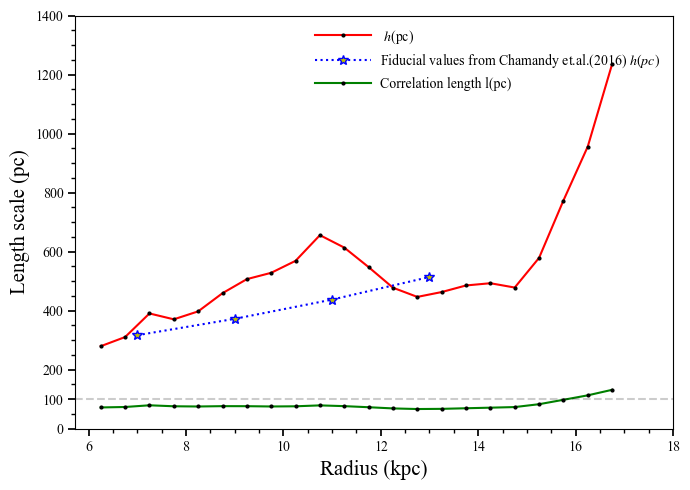

In [4]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, h_f*pc_kpc/cm_kpc, c='r', linestyle='-', mfc='k',
              mec='k', markersize=m, marker='o', label=r' $h$(pc)')
ax.plot(kpc_dat_r, pc_dat_h, c='b', linestyle='dotted', 
              marker='*',mfc='y',mec='b',mew=1, markersize = 7, label=r'Fiducial values from Chamandy et.al.(2016) $h(pc)$')
ax.plot(kpc_r, l_f*pc_kpc/cm_kpc, c='g',
              linestyle='-', mfc='k', mec='k', markersize=m, marker='o', label=r'Correlation length l(pc)')
# ax.plot(kpc_r, datamaker(lsn , data_pass, h_f, tau_f)*pc_kpc/cm_kpc,c = 'y',linestyle='--',mfc='k',mec='k', marker='o')
ax.axhline(y=100, color='black', linestyle='--', alpha = 0.2)
ax.set_yticks(list(plt.yticks()[0])+[100])
axis_pars(ax)
fill_error(ax, h_f*pc_kpc/cm_kpc, h_err*pc_kpc/cm_kpc)
ax.set_xlabel(r'Radius (kpc)', fontsize=fs)
ax.set_ylabel(r'Length scale (pc)', fontsize=fs)


### plotting u

Text(0, 0.5, 'Speed (km/s)')

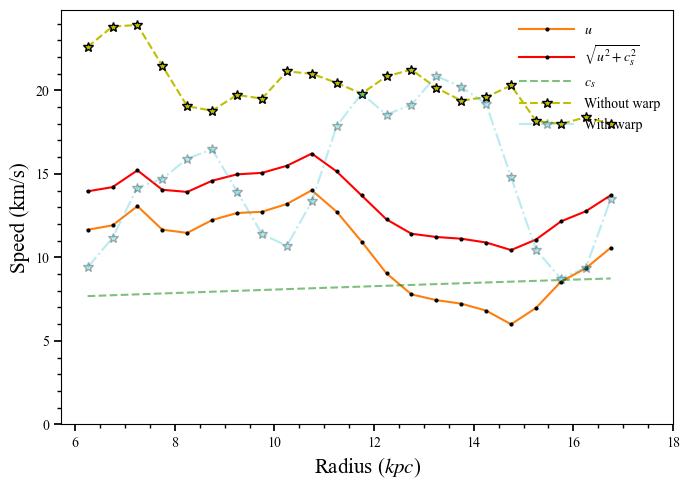

In [5]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(kpc_r, u_f/cm_km, color='tab:orange', marker='o', mfc='k',
              mec='k', markersize=m, label=r'$u$')
fill_error(ax, u_f/cm_km,u_err/cm_km, 'tab:orange', 0.5)

# ax.plot(kpc_r, alphak_f/cm_km, color='b', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_k$')
# fill_error(ax, alphak_f/cm_km,alphak_err/cm_km, 'blue')

# ax.plot(kpc_r, alpham_f/cm_km, color='r', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_m$')
# ax.plot(kpc_r, alphasat_f/cm_km, color='m', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_{sat}$')

sig = np.sqrt(u_f**2 + cs_f**2) 
ax.plot(kpc_r, sig /
              cm_km, color='r', marker='o', mfc='k', mec='k', markersize=m, label=r'$\sqrt{u^2+c_s^2}$')
fill_error(ax, sig /cm_km,np.sqrt((u_f*u_err)**2 + (cs_f*cs_err)**2)/(sig*cm_km), 'r')

ax.plot(kpc_r, cs_f /
              cm_km, color='g', linestyle='--', label=r'$c_s$', alpha = 0.5)
fill_error(ax, cs_f/cm_km,cs_err/cm_km, 'green')

ax.plot(kpc_r, dat_u/cm_km, 
              c='y', linestyle='--', label='Without warp',alpha = 1,marker='*',mfc='y'
,mec='k',mew=1, markersize = 7)
ax.plot(kpc_r, dat_u_warp/cm_km, 
              c='tab:cyan',  linestyle='dashdot', label='With warp', alpha = 0.3,marker='*',mfc='tab:cyan'
,mec='k',mew=1, markersize = 7)
axis_pars(ax)

ax.set_ylim(0)
ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.set_ylabel(r'Speed (km/s)',  fontsize=fs)


### plotting magnetic fields

In [6]:
bani_f

array([3.14564248e-06, 2.74692937e-06, 2.16782554e-06, 2.73176988e-06,
       2.85004931e-06, 2.43787133e-06, 2.20910588e-06, 2.06985128e-06,
       1.73583895e-06, 1.42505822e-06, 1.70927077e-06, 2.34244405e-06,
       3.43225161e-06, 3.90400489e-06, 3.72386205e-06, 3.49296690e-06,
       3.17562506e-06, 2.75945157e-06, 2.60490708e-06, 2.56933069e-06,
       2.15998786e-06, 1.63668704e-06])

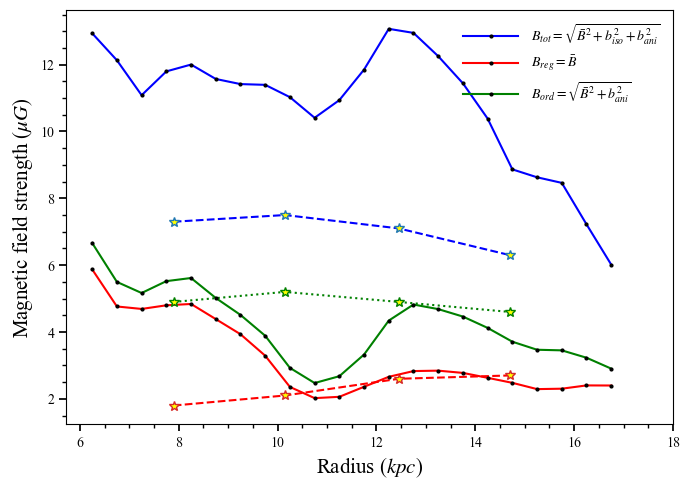

In [7]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(mrange, G_dat_Btot, c='b', linestyle='--', marker='*',mfc='yellow',mec
='tab:blue',mew=1,markersize = 7)#, label='Average Binned data $B_{tot}$ ($\mu G$)')
ax.plot(kpc_r, G_scal_Bbartot*1e+6, c='b', linestyle='-', marker='o', mfc='k', mec='k',
              markersize=m, label=r' $B_{tot}=\sqrt{\bar{B}^2+b_{iso}^2+b_{ani}^2}$')
fill_error(ax, G_scal_Bbartot*1e+6,G_scal_Bbartot_err*1e+6, 'b')

ax.plot(mrange, G_dat_Breg, c='r', linestyle='--', marker='*',mfc='yellow',mec
='tab:red',mew=1,markersize = 7)#, label='Average Binned data $B_{reg}$ ($\mu G$)')
ax.plot(kpc_r, G_scal_Bbarreg*1e+6, c='r', linestyle='-', marker='o',
              mfc='k', mec='k', markersize=m, label=r' $B_{reg} = \bar{B}$')
fill_error(ax, G_scal_Bbarreg*1e+6,G_scal_Bbarreg_err*1e+6, 'r', 0.2)


ax.plot(mrange, G_dat_Bord, c='g', linestyle='dotted', marker='*',mfc='yellow'
,mec='green',mew=1,markersize = 7)#, label='Average Binned data $B_{ord}$ ($\mu G$)')
ax.plot(kpc_r, G_scal_Bbarord*1e+6, c='green', linestyle='-', marker='o', mfc='k',
              mec='k', markersize=m, label=r' $B_{ord} = \sqrt{\bar{B}^2+b_{ani}^2}$')
fill_error(ax, G_scal_Bbarord*1e+6,G_scal_Bbarord_err*1e+6, 'g', 0.2)


ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.xaxis.set_ticks(np.arange(6, 20, 2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_ylabel('Magnetic field strength ($\mu G$)', fontsize=fs)
axis_pars(ax)


Text(0, 0.5, 'Pitch angle (deg)')

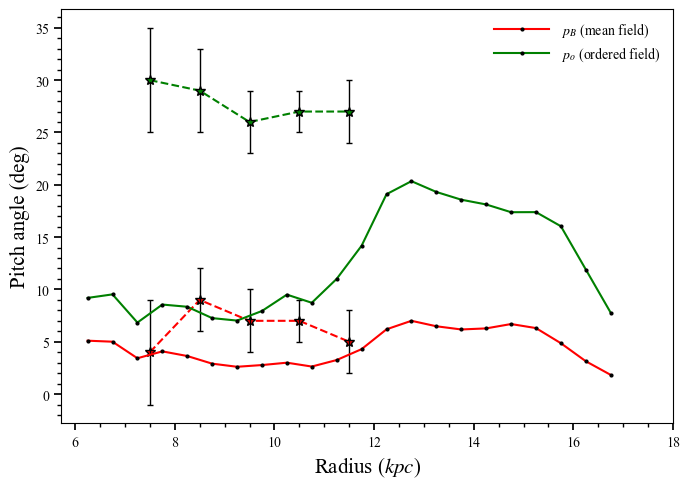

In [8]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.errorbar(rmrange, 180*RM_dat_pb/np.pi,elinewidth=1, yerr=180*err_RM_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
                  c='r', linestyle='--', mfc='r', mec='k',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
ax.errorbar(rmrange, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
                  c='g', linestyle='--', marker='*', mfc='g', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')

ax.plot(kpc_r, 180*pB/np.pi, c='r', linestyle='-', marker='o',
              markersize=m, mfc='k', mec='k', label=r' $p_{B}$ (mean field)')
fill_error(ax, 180*pB/np.pi,180*pB_err/np.pi, 'r')
# ax.plot(kpc_r, 180*pbb/np.pi,c = 'r',linestyle='--', marker='o',label = r' $p_{b}$ (anisotropic field)')
ax.plot(kpc_r, 180*pog/np.pi, c='g', linestyle='-', mfc='k', markersize=m,
        
              mec='k', marker='o', label=r' $p_{o}$ (ordered field)')
fill_error(ax, 180*pog/np.pi,180*pog_err/np.pi, 'g')

axis_pars(ax)
ax.set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax.set_ylabel(r'Pitch angle (deg)', fontsize=fs)


In [9]:
# fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

# from get_magnetic_observables import omt, kah, taue_f, taur_f

# ax.axhline(y=1, color='g', linestyle='-', label=r'1')
# ax.plot(kpc_r, omt, marker='o', markersize=m,
#               c='tab:orange', mfc='k', mec='k', label=r'$\Omega\tau$')
# ax.plot(kpc_r, kah, marker='o',
#               markersize=m, c='tab:blue', mfc='k', mec='k', label=r'$\frac{K_\alpha h}{C_\alpha \tau u}$')
# axis_pars(ax)
# ax.set_xlabel('Radius(kpc)', fontsize=fs)
# ax.set_ylabel(r'Condition for $\alpha_k$ (Myr)', fontsize=fs)







In [10]:
# fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
# ax.plot(kpc_r, taue_f/s_Myr, c='b', markersize=m,
#               linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^e$')
# ax.plot(kpc_r, taur_f/s_Myr, c='g',
#               markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^r$')
# # ax.plot(kpc_r, h_f/(u_f*s_Myr), c='y', markersize=m,
# #               linestyle='-', marker='o', mfc='k', mec='k', label=r'$h/u$')
# ax.set_xlabel('Radius(kpc)', fontsize=fs)
# ax.set_ylabel(r'Correlation Time $\tau$ (Myr)', fontsize=fs)
# axis_pars(ax)


In [11]:
# fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

# os.chdir(current_directory + '\expressions')
# from expressions.magnetic_expressions import Dk, Dc

# dkdc_f = datamaker((Dk/Dc), data_pass, h_f, tau_f, alphak_f)
# alpham_f = alphak_f*((1/dkdc_f)-1)

# alphasat_f = alphak_f + alpham_f
# ax.plot(kpc_r, dkdc_f, markersize=m, linestyle='-',
#               marker='o', mfc='k', mec='k', label=r'$D_k/D_c$')
# ax.plot(kpc_r, 1*np.ones(len(kpc_r)))
# ax.set_xlabel('Radius(kpc)', fontsize=fs)
# ax.set_ylabel(r'$D_k/D_c$',  fontsize=fs)
# axis_pars(ax)

In [12]:
# fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
# ax.plot(kpc_r, (((np.pi**2)*(tau_f*(u_f**2))/3*(np.sqrt(dkdc_f)-1)/(4*h_f**2))**(-1))/
#               (s_Myr*1e+3), c='g', markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\gamma$')
# ax.set_xlabel('Radius(kpc)', fontsize=fs)
# ax.set_ylabel(r'local e-folding time $\gamma$ (Gyr)', fontsize=fs)
# ax.legend(fontsize = lfs)

In [13]:
# dat_sigmatot, dat_sigma, dat_sigmasfr, dat_q, dat_omega, zet, T_tb, psi, bet, ca, rk, mu = (
#     np.array([data_pass[i][j] for i in range(len(kpc_r))]) for j in range(len(data_pass[0])))
# from helper_functions import g_Msun
# ks_const = (dat_sigmasfr/(dat_sigma)**(1.4)).mean()
# dat_sigmasfr2 = ks_const*(dat_sigma)**(1.4)
# dat_sigma3 = ((1/ks_const)*(dat_sigmasfr))**(1/1.4)
# fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)

# ax.plot(kpc_r, dat_sigmasfr*(cm_kpc**2)*(s_Myr/1e+6)/g_Msun, c='r',
#            linestyle='--', mfc='k', mec='k', markersize=m, marker='o', label=r'original $\Sigma_{SFR}$ data')
# ax.plot(kpc_r, dat_sigmasfr2*(cm_kpc**2)*(s_Myr/1e+6)/g_Msun, c='b', linestyle='--',
#            mfc='k', mec='k', markersize=m, marker='o', label=r'$\Sigma_{SFR} \propto \Sigma_{dat}^{1.4}$ ')
# # ax.plot(kpc_r, dat_sigmasfr3*(cm_kpc**2)*(s_Myr/1e+6)/g_Msun, c='g', linestyle='--',
# #            mfc='k', mec='k', markersize=m, marker='o', label=r'$\Sigma \propto \Sigma_{SFRdat}^{1/1.4}$')
# ax.set_xlabel('Radius(kpc)',fontsize=fs)
# ax.set_ylabel(r'$\Sigma_{SFR}$ ($\mathrm{M_\odot\,yr^{-1}kpc^{-2}}$)',fontsize=fs)
# axis_pars(ax)


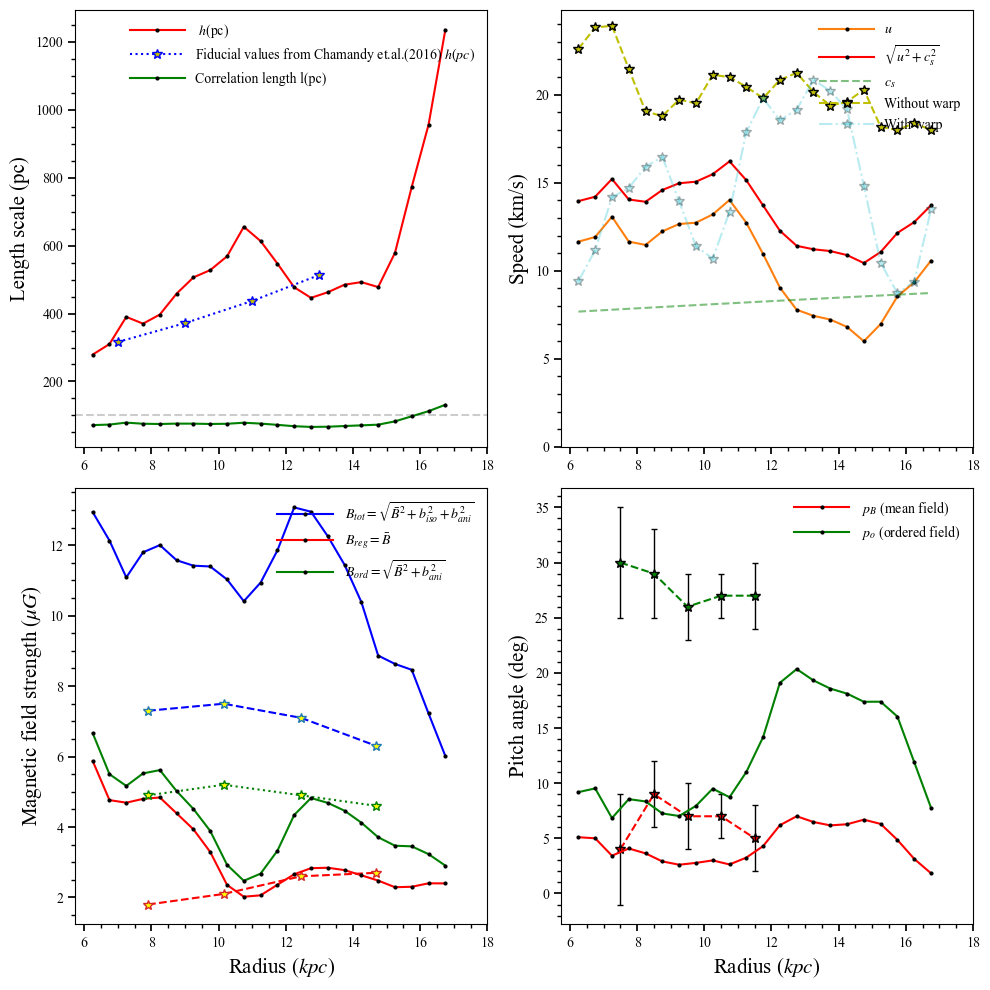

In [14]:
os.chdir(current_directory+'\plots')

from matplotlib.backends.backend_pdf import PdfPages
PDF = PdfPages('sb_model3_ca_'+str(params[r'C_\alpha'])+'rk_'+str(params[r'R_\kappa'])+'z_'+str(
     params[r'\zeta'])+'psi_'+str(params[r'\psi'])+'b_'+str(params[r'\beta'])+'.pdf')#('plots_model'+str(model_no)+let+'t_vary_'+'ca_'+str(ca)+'rk_'+str(rk)+'z_'+str(z.mean())+'.pdf')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)
i = 0
j = 0
ax[i][j].plot(kpc_r, h_f*pc_kpc/cm_kpc, c='r', linestyle='-', mfc='k',
              mec='k', markersize=m, marker='o', label=r' $h$(pc)')
ax[i][j].plot(kpc_dat_r, pc_dat_h, c='b', linestyle='dotted', 
              marker='*',mfc='y',mec='b',mew=1, markersize = 7, label=r'Fiducial values from Chamandy et.al.(2016) $h(pc)$')
ax[i][j].plot(kpc_r, l_f*pc_kpc/cm_kpc, c='g',
              linestyle='-', mfc='k', mec='k', markersize=m, marker='o', label=r'Correlation length l(pc)')
# ax[i][j].plot(kpc_r, datamaker(lsn , data_pass, h_f, tau_f)*pc_kpc/cm_kpc,c = 'y',linestyle='--',mfc='k',mec='k', marker='o')
ax[i][j].axhline(y=100, color='black', linestyle='--', alpha = 0.2)
#ax[i][j].set_yticks(list(plt.yticks()[0])+[100])
axis_pars(ax[i][j])
fill_error(ax[i][j], h_f*pc_kpc/cm_kpc, h_err*pc_kpc/cm_kpc)
#ax[i][j].set_xlabel(r'Radius (kpc)', fontsize=fs)
ax[i][j].set_ylabel(r'Length scale (pc)', fontsize=fs)


i = 0
j = 1
ax[i][j].plot(kpc_r, u_f/cm_km, color='tab:orange', marker='o', mfc='k',
              mec='k', markersize=m, label=r'$u$')
fill_error(ax[i][j], u_f/cm_km,u_err/cm_km, 'tab:orange', 0.5)

# ax[i][j].plot(kpc_r, alphak_f/cm_km, color='b', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_k$')
# fill_error(ax[i][j], alphak_f/cm_km,alphak_err/cm_km, 'blue')

# ax[i][j].plot(kpc_r, alpham_f/cm_km, color='r', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_m$')
# ax[i][j].plot(kpc_r, alphasat_f/cm_km, color='m', marker='o',
#               mfc='k', mec='k', markersize=m, label=r'$\alpha_{sat}$')

sig = np.sqrt(u_f**2 + cs_f**2) 
ax[i][j].plot(kpc_r, sig /
              cm_km, color='r', marker='o', mfc='k', mec='k', markersize=m, label=r'$\sqrt{u^2+c_s^2}$')
fill_error(ax[i][j], sig /cm_km,np.sqrt((u_f*u_err)**2 + (cs_f*cs_err)**2)/(sig*cm_km), 'r')

ax[i][j].plot(kpc_r, cs_f /
              cm_km, color='g', linestyle='--', label=r'$c_s$', alpha = 0.5)
fill_error(ax[i][j], cs_f/cm_km,cs_err/cm_km, 'green')

ax[i][j].plot(kpc_r, dat_u/cm_km, 
              c='y', linestyle='--', label='Without warp',alpha = 1,marker='*',mfc='y'
,mec='k',mew=1, markersize = 7)
ax[i][j].plot(kpc_r, dat_u_warp/cm_km, 
              c='tab:cyan',  linestyle='dashdot', label='With warp', alpha = 0.3,marker='*',mfc='tab:cyan'
,mec='k',mew=1, markersize = 7)
axis_pars(ax[i][j])

ax[i][j].set_ylim(0)
#ax[i][j].set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax[i][j].set_ylabel(r'Speed (km/s)',  fontsize=fs)

i = 1
ax[i][j].errorbar(rmrange, 180*RM_dat_pb/np.pi,elinewidth=1, yerr=180*err_RM_dat_pb/np.pi,ecolor='k', ms=7, mew=1, capsize=2,
                  c='r', linestyle='--', mfc='r', mec='k',barsabove=True,marker='*')#, label=r'Data $p_{B}$ (mean field)(RM)')
ax[i][j].errorbar(rmrange, 180*RM_dat_po/np.pi,elinewidth=1, yerr=180*err_RM_dat_po/np.pi, ms=7, mew=1, capsize=2,
                  c='g', linestyle='--', marker='*', mfc='g', mec='k',ecolor='k')#, label=r'Data $p_{o}$ (ordered field)(RM)')

ax[i][j].plot(kpc_r, 180*pB/np.pi, c='r', linestyle='-', marker='o',
              markersize=m, mfc='k', mec='k', label=r' $p_{B}$ (mean field)')
fill_error(ax[i][j], 180*pB/np.pi,180*pB_err/np.pi, 'r')
# ax[i][j].plot(kpc_r, 180*pbb/np.pi,c = 'r',linestyle='--', marker='o',label = r' $p_{b}$ (anisotropic field)')
ax[i][j].plot(kpc_r, 180*pog/np.pi, c='g', linestyle='-', mfc='k', markersize=m,
        
              mec='k', marker='o', label=r' $p_{o}$ (ordered field)')
fill_error(ax[i][j], 180*pog/np.pi,180*pog_err/np.pi, 'g')

axis_pars(ax[i][j])
ax[i][j].set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax[i][j].set_ylabel(r'Pitch angle (deg)', fontsize=fs)

j= 0
ax[i][j].plot(mrange, G_dat_Btot, c='b', linestyle='--', marker='*',mfc='yellow',mec
='tab:blue',mew=1,markersize = 7)#, label='Average Binned data $B_{tot}$ ($\mu G$)')
ax[i][j].plot(kpc_r, G_scal_Bbartot*1e+6, c='b', linestyle='-', marker='o', mfc='k', mec='k',
              markersize=m, label=r' $B_{tot}=\sqrt{\bar{B}^2+b_{iso}^2+b_{ani}^2}$')
fill_error(ax[i][j], G_scal_Bbartot*1e+6,G_scal_Bbartot_err*1e+6, 'b')

ax[i][j].plot(mrange, G_dat_Breg, c='r', linestyle='--', marker='*',mfc='yellow',mec
='tab:red',mew=1,markersize = 7)#, label='Average Binned data $B_{reg}$ ($\mu G$)')
ax[i][j].plot(kpc_r, G_scal_Bbarreg*1e+6, c='r', linestyle='-', marker='o',
              mfc='k', mec='k', markersize=m, label=r' $B_{reg} = \bar{B}$')
fill_error(ax[i][j], G_scal_Bbarreg*1e+6,G_scal_Bbarreg_err*1e+6, 'r', 0.2)


ax[i][j].plot(mrange, G_dat_Bord, c='g', linestyle='dotted', marker='*',mfc='yellow'
,mec='green',mew=1,markersize = 7)#, label='Average Binned data $B_{ord}$ ($\mu G$)')
ax[i][j].plot(kpc_r, G_scal_Bbarord*1e+6, c='green', linestyle='-', marker='o', mfc='k',
              mec='k', markersize=m, label=r' $B_{ord} = \sqrt{\bar{B}^2+b_{ani}^2}$')
fill_error(ax[i][j], G_scal_Bbarord*1e+6,G_scal_Bbarord_err*1e+6, 'g', 0.2)


ax[i][j].set_xlabel(r'Radius ($kpc$)', fontsize=fs)
ax[i][j].xaxis.set_ticks(np.arange(6, 20, 2))
ax[i][j].xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[i][j].set_ylabel('Magnetic field strength ($\mu G$)', fontsize=fs)
axis_pars(ax[i][j])


PDF.savefig(fig)

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), tight_layout=True)

# i = 0

# ax[i][j].axhline(y=1, color='g', linestyle='-', label=r'1')
# ax[i][j].plot(kpc_r, omt, marker='o', markersize=m,
#               c='tab:orange', mfc='k', mec='k', label=r'$\Omega\tau$')
# ax[i][j].plot(kpc_r, kah, marker='o',
#               markersize=m, c='tab:blue', mfc='k', mec='k', label=r'$\frac{K_\alpha h}{C_\alpha \tau u}$')
# axis_pars(ax[i][j])
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'Condition for $\alpha_k$ (Myr)', fontsize=fs)


# j = 1
# ax[i][j].plot(kpc_r, taue_f/s_Myr, c='b', markersize=m,
#               linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^e$')
# ax[i][j].plot(kpc_r, taur_f/s_Myr, c='g',
#               markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\tau^r$')
# # ax[i][j].plot(kpc_r, h_f/(u_f*s_Myr), c='y', markersize=m,
# #               linestyle='-', marker='o', mfc='k', mec='k', label=r'$h/u$')
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'Correlation Time $\tau$ (Myr)', fontsize=fs)
# axis_pars(ax[i][j])

# i = 1
# ax[i][j].plot(kpc_r, dkdc_f, markersize=m, linestyle='-',
#               marker='o', mfc='k', mec='k', label=r'$D_k/D_c$')
# ax[i][j].plot(kpc_r, 1*np.ones(len(kpc_r)))
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'$D_k/D_c$',  fontsize=fs)
# axis_pars(ax[i][j])

# j = 0
# ax[i][j].plot(kpc_r, (((np.pi**2)*(tau_f*(u_f**2))/3*(np.sqrt(dkdc_f)-1)/(4*h_f**2))**(-1))/
#               (s_Myr*1e+3), c='g', markersize=m, linestyle='-', marker='o', mfc='k', mec='k', label=r'$\gamma$')
# ax[i][j].set_xlabel('Radius(kpc)', fontsize=fs)
# ax[i][j].set_ylabel(r'local e-folding time $\gamma$ (Gyr)', fontsize=fs)
# ax[i][j].legend(fontsize = lfs)

# PDF.savefig(fig)
PDF.close()
os.chdir(current_directory)


In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sympy import *
# from fractions import Fraction
# import pickle
# import os
# from matplotlib.ticker import FormatStrFormatter
# import sys
# from scipy.interpolate import griddata
# from helper_functions import scal_finder


# q = Symbol('q')
# omega = Symbol('\Omega')
# sigma = Symbol('\Sigma')
# sigmatot = Symbol('Sigma_tot')
# sigmasfr = Symbol('Sigma_SFR')
# T = Symbol('T')
# calpha = Symbol('C_alpha')
# gamma = Symbol('gamma')
# boltz = Symbol('k_B')
# mu = Symbol('mu')
# mh = Symbol('m_H')
# G = Symbol('G')
# xio = Symbol('xi_0')
# delta = Symbol('\delta')
# mstar = Symbol('m_*')
# cl = Symbol('C_l')
# kappa = Symbol('kappa')
# mach = Symbol('M')
# E51 = Symbol('E_51')
# Rk = Symbol('R_k')
# zet = Symbol('zeta')
# psi = Symbol('psi')
# kalpha = Symbol('K_alpha')
# bet = Symbol('beta')
# alphak = Symbol('alpha_k')
# Gamma = Symbol('Gamma')

# current_directory = str(os.getcwd())


In [16]:
# os.chdir(current_directory + '\expressions')
# with open('turb_exp.pickle', 'rb') as f:
#     hg, rho, nu, u, l, taue, taur, alphak1, alphak2, alphak3 = pickle.load(f)

# with open('mag_exp.pickle', 'rb') as f:
#     biso, bani, Bbar, tanpb, tanpB, Beq, eta, cs = pickle.load(f)

# os.chdir(current_directory + '\data')
# with open('zip_data.pickle', 'rb') as f:
#     kpc_r, data_pass = pickle.load(f)
# r = kpc_r.size
# #q ,omega ,sigma,sigmatot,sigmasfr, T
# observables = [T]
# quantities = [hg, l, u, cs, alphak1, taue, biso, bani, Bbar, tanpB, tanpb]

# exps = []
# for i,quan in enumerate(quantities):
#     exps_quan = np.array([scal_finder(hg, quan, obs, data_pass, taue, alphak1, np.linspace(1,5000,100), 1e+25)[2] for obs in observables])
#     exps.append(exps_quan)

# os.chdir(current_directory)
